In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

from synth_dim_model import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd
import scipy.linalg

import warnings
warnings.filterwarnings("ignore")

In [2]:
# single site operators

x_plus_1 = np.array(np.matrix([[0,0,0],[0,0,0],[0,1,0]]))
x_minus_1 = np.array(np.matrix([[0,0,0],[0,0,1],[0,0,0]]))
x_plus_2 = np.array(np.matrix([[0,1,0],[0,0,0],[0,0,0]]))
x_minus_2 = np.array(np.matrix([[0,0,0],[1,0,0],[0,0,0]]))

T_plus_1_1 = np.array(np.matrix([[0,0,0],[0,1,0],[0,0,-1]]))
T_minus_1_1 = T_plus_1_1
T_plus_1_2 = np.array(np.matrix([[0,0,0],[0,0,0],[-1,0,0]]))
T_minus_1_2 = np.array(np.matrix([[0,0,-1],[0,0,0],[0,0,0]]))
T_plus_2_1 = T_minus_1_2
T_minus_2_1 = T_plus_1_2
T_plus_2_2 = np.array(np.matrix([[-1,0,0],[0,1,0],[0,0,0]]))
T_minus_2_2 = T_plus_2_2

id = np.eye(3)

In [3]:
# manual operator definitions for two sites

psi_plus_1_1 = np.kron(x_plus_1,id)
psi_minus_1_1 = np.kron(x_minus_1,id)
psi_plus_1_2 = np.kron(x_plus_2,id)
psi_minus_1_2 = np.kron(x_minus_2,id)

psi_plus_2_1 = np.kron(T_plus_1_1, x_plus_1) + np.kron(T_plus_1_2, x_plus_2)
psi_minus_2_1 = np.kron(T_minus_1_1, x_minus_1) + np.kron(T_minus_1_2, x_minus_2)
psi_plus_2_2 = np.kron(T_plus_2_1, x_plus_1) + np.kron(T_plus_2_2, x_plus_2)
psi_minus_2_2 = np.kron(T_minus_2_1, x_minus_1) + np.kron(T_minus_2_2, x_minus_2)

n_1 = psi_plus_1_1 @ psi_minus_1_1 + psi_plus_1_2 @ psi_minus_1_2
n_2 = psi_plus_2_1 @ psi_minus_2_1 + psi_plus_2_2 @ psi_minus_2_2
total_n = n_1 + n_2

In [4]:
import numpy as np
from itertools import product

# Identity for single site
id3 = np.eye(3)

# Define x^{(±)}_{i,alpha}
x_matrices = {
    ('+', 1): np.array([[0, 0, 0], [0, 0, 0], [0, 1, 0]]),
    ('-', 1): np.array([[0, 0, 0], [0, 0, 1], [0, 0, 0]]),
    ('+', 2): np.array([[0, 1, 0], [0, 0, 0], [0, 0, 0]]),
    ('-', 2): np.array([[0, 0, 0], [1, 0, 0], [0, 0, 0]]),
}

# Define T^{(±)}_{k,alpha,beta}
T_matrices = {
    ('+', 1, 1): np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),
    ('-', 1, 1): np.array([[0, 0, 0], [0, 1, 0], [0, 0, -1]]),
    ('+', 1, 2): np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]]),
    ('-', 1, 2): np.array([[0, 0, -1], [0, 0, 0], [0, 0, 0]]),
    ('+', 2, 1): np.array([[0, 0, -1], [0, 0, 0], [0, 0, 0]]),
    ('-', 2, 1): np.array([[0, 0, 0], [0, 0, 0], [-1, 0, 0]]),
    ('+', 2, 2): np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),
    ('-', 2, 2): np.array([[-1, 0, 0], [0, 1, 0], [0, 0, 0]]),
}

def build_paraparticle_operator(N, site_index, alpha, sign):
    assert 1 <= site_index <= N
    assert alpha in [1, 2]
    assert sign in ['+', '-']

    total_op = np.zeros((3**N, 3**N))

    # Generate all beta chains of length (site_index - 1)
    for beta_chain in product([1, 2], repeat=site_index - 1):
        op_list = []

        # Construct the x^{(sign)}_{i,beta_{i-1}} part
        beta_prev = beta_chain[-1] if beta_chain else alpha
        x_op = x_matrices[(sign, beta_prev)]
        op_list.append(x_op)

        # Build T^{(sign)} chain in reverse site order
        for k in reversed(range(site_index - 1)):
            beta_k = beta_chain[k]
            beta_k_minus_1 = alpha if k == 0 else beta_chain[k - 1]
            T_k = T_matrices[(sign, beta_k_minus_1, beta_k)]
            op_list.insert(0, T_k)  # prepend

        # Pad identity operators
        full_op_list = (
            [id3] * (site_index - len(op_list)) + op_list + [id3] * (N - site_index)
        )

        # Compute full Kronecker product
        kron_op = full_op_list[0]
        for m in range(1, len(full_op_list)):
            kron_op = np.kron(kron_op, full_op_list[m])

        total_op += kron_op

    return total_op


def construct_site_paraparticle_number_operator(N, site_index):
    assert 1 <= site_index <= N
    n_i = np.zeros((3**N, 3**N))

    for alpha in [1, 2]:
        psi_plus = build_paraparticle_operator(N, site_index, alpha, '+')
        psi_minus = build_paraparticle_operator(N, site_index, alpha, '-')
        n_i += psi_plus @ psi_minus

    return n_i

def construct_total_paraparticle_number_operator(N):
    total_n = np.zeros((3**N, 3**N))
    for i in range(1, N + 1):
        total_n += construct_site_paraparticle_number_operator(N, i)
    return total_n

In [5]:
import numpy as np

def exact_diagonalize_with_total_paraparticle_number_symmetry(hamiltonian, total_paraparticle_number_operator):
    """
    Diagonalizes a Hamiltonian within symmetry sectors defined by the total paraparticle number operator.
    
    Args:
        hamiltonian (np.ndarray): The Hamiltonian matrix.
        total_paraparticle_number_operator (np.ndarray): The symmetry operator (should commute with H).
    
    Returns:
        eigenvalues (np.ndarray): 1D array of all eigenvalues.
        eigenvectors (list of np.ndarray): List of eigenvectors (each is 1D, in original basis).
        total_paraparticle_numbers (np.ndarray): Expectation values of total paraparticle number in each eigenstate.
    """
    # Diagonalize the symmetry operator
    eigvals_symm, V_N = np.linalg.eigh(total_paraparticle_number_operator)

    # Rotate Hamiltonian into symmetry eigenbasis
    number_basis_ham = V_N.conj().T @ hamiltonian @ V_N

    # Identify unique symmetry sectors
    unique_sectors = np.unique(np.round(eigvals_symm, decimals=10))  # rounded for numerical stability
    sector_indices = {
        sector: np.where(np.isclose(eigvals_symm, sector, atol=1e-10))[0]
        for sector in unique_sectors
    }

    # Diagonalize each symmetry sector
    sector_eigenvalues = {}
    sector_eigenvectors = {}
    for sector, indices in sector_indices.items():
        block = number_basis_ham[np.ix_(indices, indices)]
        e_vals, e_vecs = np.linalg.eigh(block)
        sector_eigenvalues[sector] = e_vals
        sector_eigenvectors[sector] = e_vecs

    # Construct full eigenvectors in symmetry basis
    dim = hamiltonian.shape[0]
    full_symm_evecs = np.zeros((dim, dim), dtype=complex)
    for sector, indices in sector_indices.items():
        block_evecs = sector_eigenvectors[sector]
        idx = np.ix_(indices, indices)
        full_symm_evecs[idx] = block_evecs

    # Rotate back to original basis
    full_eigenvectors = V_N @ full_symm_evecs

    # Gather eigenvalues and eigenvectors
    full_eigenvalues = np.concatenate([sector_eigenvalues[sector] for sector in unique_sectors])
    eigenvectors = [full_eigenvectors[:, i] for i in range(full_eigenvectors.shape[1])]

    # Compute total paraparticle number in each eigenstate
    total_ns = [
        np.real_if_close(vec.conj().T @ total_paraparticle_number_operator @ vec)
        for vec in eigenvectors
    ]

    return full_eigenvalues, eigenvectors, np.array(total_ns)


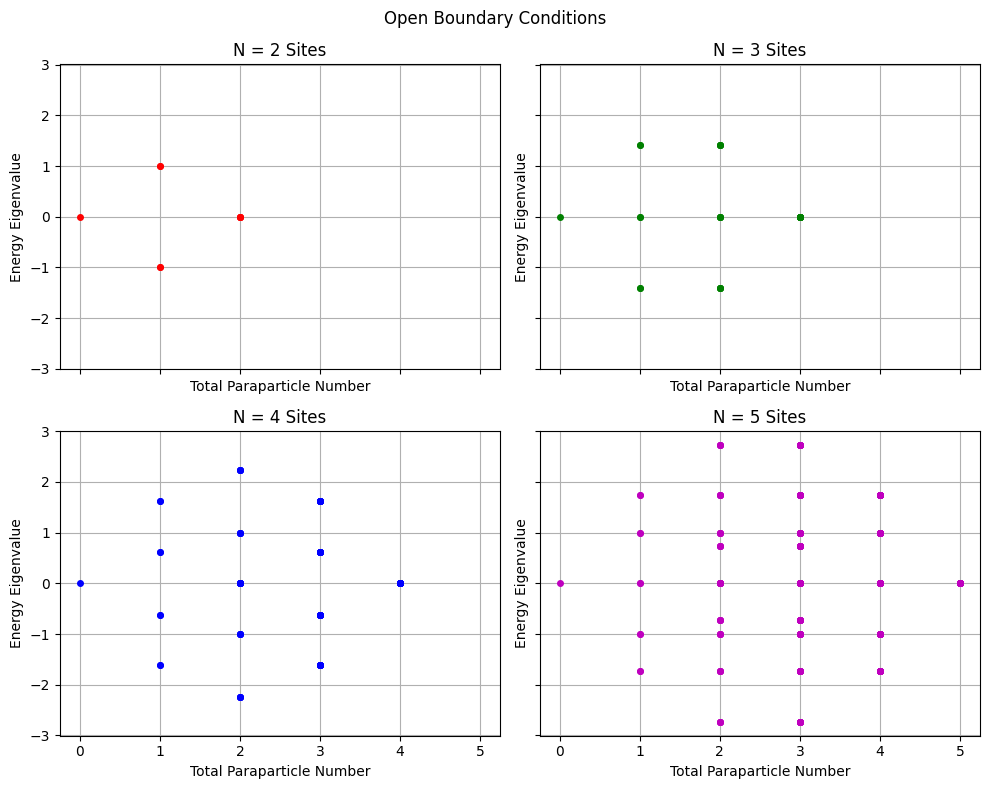

In [6]:
M = 3
V = 1
Ns = [2, 3, 4, 5]
colors = ["r", "g", "b", "m"]

fig, axes = plt.subplots(nrows=2, ncols=2, sharex = True, sharey = True, figsize=(10, 8))  # 2x2 grid
axes = axes.flatten()  # flatten to 1D array for easy indexing

for i, N in enumerate(Ns):
    hamiltonian = construct_hamiltonian(N, M, V, mu=0, J=0)
    total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)
    eigenvalues, eigenvectors, ns = exact_diagonalize_with_total_paraparticle_number_symmetry(
        hamiltonian, total_paraparticle_number_operator
    )

    ax = axes[i]
    ax.plot(ns, eigenvalues, '.', color = colors[i], markersize = 8)
    ax.set_xlabel("Total Paraparticle Number")
    ax.set_ylabel("Energy Eigenvalue")
    ax.set_title(f"N = {N} Sites")
    ax.grid()
fig.suptitle("Open Boundary Conditions")
fig.tight_layout()
plt.show()


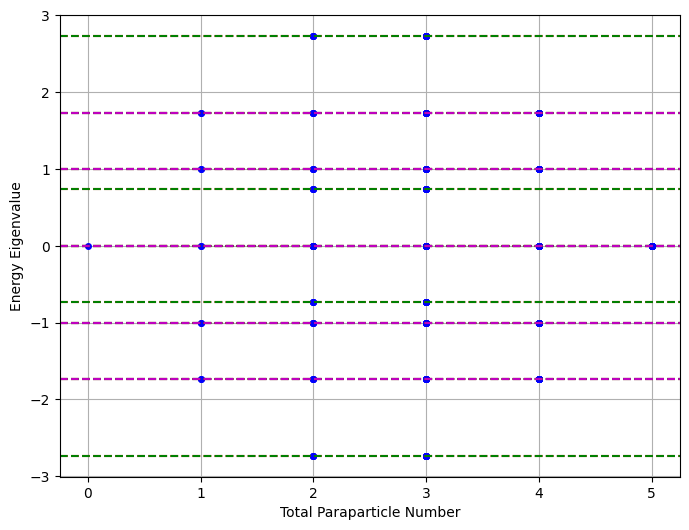

In [7]:
from itertools import combinations

M = 3
N = 5

V = 1
mu = 0

hamiltonian = construct_hamiltonian(N, M, V, mu=0, J=0, boundary_conditions="OBC")
total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)
eigenvalues, eigenvectors, ns = exact_diagonalize_with_total_paraparticle_number_symmetry(hamiltonian, total_paraparticle_number_operator)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(ns, eigenvalues, '.', color='b', markersize=8)
ax.set_xlabel("Total Paraparticle Number")
ax.set_ylabel("Energy Eigenvalue")
ax.grid()

def energy_levels(V, mu, k):
    return 2*V*np.cos(k) - mu

def k_value_OBC(n, L):    
    return np.pi * n / (L + 1)

k_values = []
for n in range(1,N+1):
    k_values.append(k_value_OBC(n, N))
    
single_particle_energies = [energy_levels(V, mu, k) for k in k_values]
two_particle_energies = [sum(comb) for comb in combinations(single_particle_energies, 2)]
three_particle_energies = [sum(comb) for comb in combinations(single_particle_energies, 3)]
four_particle_energies = [sum(comb) for comb in combinations(single_particle_energies, 4)]
five_particle_energies = [sum(comb) for comb in combinations(single_particle_energies, 5)]
six_particle_energies = [sum(comb) for comb in combinations(single_particle_energies, 6)]

for single_particle_energy in single_particle_energies:
    ax.axhline(single_particle_energy, color = "k", linestyle='--', label='Single Particle Energies')

for two_particle_energy in two_particle_energies:
    ax.axhline(two_particle_energy, color = "r", linestyle='--', label='Two Particle Energies')
    
for three_particle_energy in three_particle_energies:
    ax.axhline(three_particle_energy, color = "g", linestyle='--', label='Three Particle Energies')
    
for four_particle_energy in four_particle_energies:
    ax.axhline(four_particle_energy, color = "m", linestyle='--', label='Four Particle Energies')
    

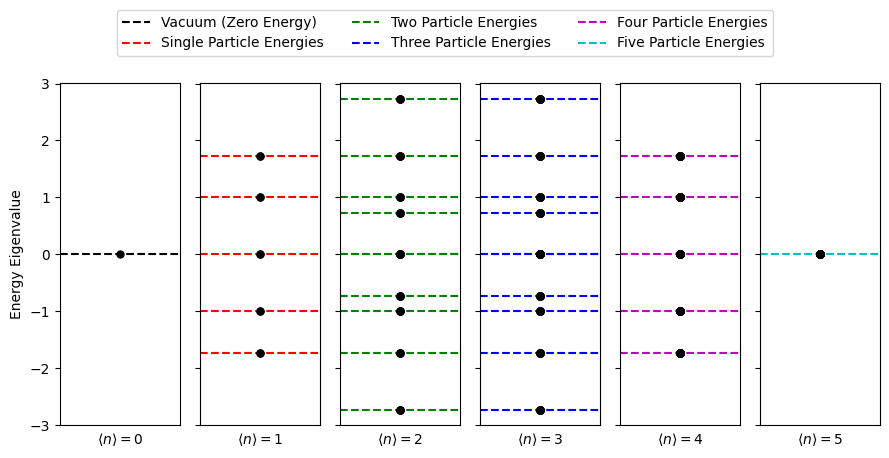

In [8]:
numbers = [0,1,2,3,4,5]
fig, axs = plt.subplots(ncols=len(numbers), figsize=(1.5*len(numbers), 4), sharey=True)

# Create legend handles manually to avoid duplicate labels
import matplotlib.lines as mlines

legend_lines = [
    mlines.Line2D([], [], color='k', linestyle='--', label='Vacuum (Zero Energy)'),
    mlines.Line2D([], [], color='r', linestyle='--', label='Single Particle Energies'),
    mlines.Line2D([], [], color='g', linestyle='--', label='Two Particle Energies'),
    mlines.Line2D([], [], color='b', linestyle='--', label='Three Particle Energies'),
    mlines.Line2D([], [], color='m', linestyle='--', label='Four Particle Energies'),
    mlines.Line2D([], [], color='c', linestyle='--', label='Five Particle Energies'),
]

for i, number in enumerate(numbers):
    xmin = number - 0.5
    xmax = number + 0.5

    if number == 0:
        axs[i].axhline(0, color='k', linestyle='--')
    
    if number == 1:
        for energy in single_particle_energies:
            axs[i].axhline(energy, color='r', linestyle='--')
    
    elif number == 2:
        for energy in two_particle_energies:
            axs[i].axhline(energy, color='g', linestyle='--')
            
    elif number == 3:
        for energy in three_particle_energies:
            axs[i].axhline(energy, color='b', linestyle='--')
            
    elif number == 4:
        for energy in four_particle_energies:
            axs[i].axhline(energy, color='m', linestyle='--')
            
    elif number == 5:
        for energy in five_particle_energies:
            axs[i].axhline(energy, color='c', linestyle='--')
            
    elif number == 6:
        for energy in six_particle_energies:
            axs[i].axhline(energy, color='y', linestyle='--')
            
    axs[i].set_xlim(xmin, xmax)
    axs[i].set_xticks([])
    axs[i].set_xlabel(f"$\\langle n \\rangle = {number}$")
    if i == 0:
        axs[i].set_ylabel("Energy Eigenvalue")
    
    axs[i].plot(ns, eigenvalues, '.', color='k', markersize=10)

# Add a single legend at the top center
fig.legend(handles=legend_lines, loc='upper center', ncol=len(numbers)/2, bbox_to_anchor=(0.5, 1.15))

fig.tight_layout()


In [9]:
N = 5
M = 3
V = 1

total_paraparticle_number_operator = construct_total_paraparticle_number_operator(N)
hamiltonian = construct_hamiltonian(N, M, V, mu = 0, J = 0)
times = np.linspace(0, 500, 2000)

# --- Construct number operators (using 1-based indices) ---
n_list = [
    construct_site_paraparticle_number_operator(N, site_index=i+1)
    for i in range(N)
]

# --- Diagonalize Hamiltonian ---
eigenvalues, eigenvectors = scipy.linalg.eigh(hamiltonian)
state = eigenvectors[:, 0]  # Ground state

# --- Heisenberg evolution function ---
def heisenberg_evolve(op, eigenvectors, eigenvalues, t):
    op_e = eigenvectors.conj().T @ op @ eigenvectors
    phase = np.exp(1j * eigenvalues * t)
    op_t_e = np.diag(phase) @ op_e @ np.diag(np.conj(phase))
    return eigenvectors @ op_t_e @ eigenvectors.conj().T

# --- Compute C_{i-j}(t) ---
max_dist = N - 1
r_vals = np.arange(-max_dist, max_dist + 1)
T = len(times)
C = np.zeros((T, len(r_vals)), dtype=complex)
counts = np.zeros(len(r_vals), dtype=int)

for t_idx, t in enumerate(times):
    for i in range(N):
        n_i_t = heisenberg_evolve(n_list[i], eigenvectors, eigenvalues, t)
        for j in range(N):
            r = i - j
            r_idx = r + max_dist
            val = np.vdot(state, n_i_t @ n_list[j] @ state)
            C[t_idx, r_idx] += val
            counts[r_idx] += 1

C /= counts  # Normalize by number of (i, j) pairs per r

KeyboardInterrupt: 

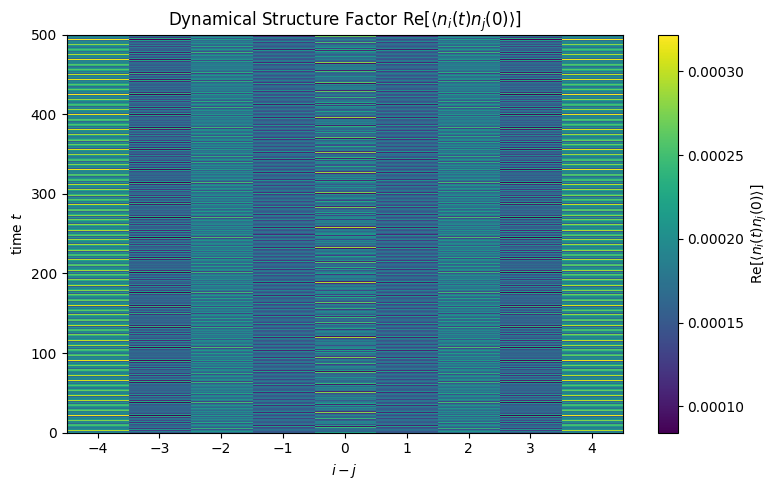

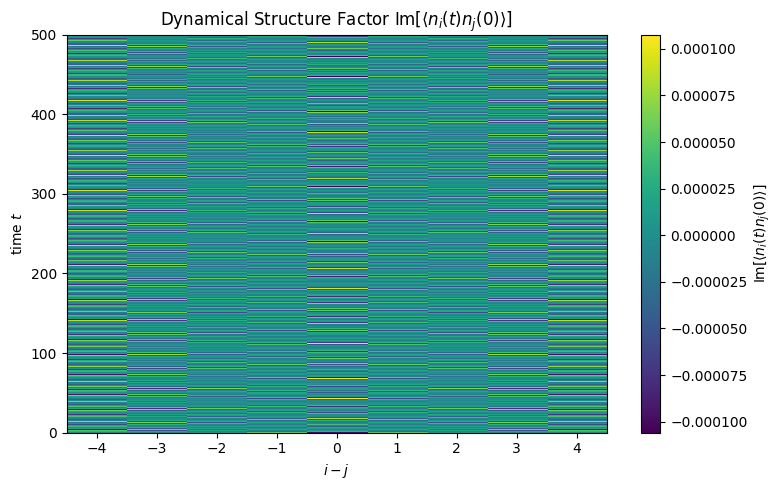

In [ ]:
# --- Plot: Real part of ⟨n_i(t) n_j(0)⟩ vs signed i-j ---
plt.figure(figsize=(8, 5))
extent = [r_vals[0] - 0.5, r_vals[-1] + 0.5, times[0], times[-1]]
plt.imshow(
    np.real(C),
    aspect='auto',
    extent=extent,
    origin='lower',
    cmap='viridis',
    interpolation='none'
)
plt.xlabel("$i - j$")
plt.ylabel("time $t$")
plt.title("Dynamical Structure Factor Re[$\\langle n_i(t) n_j(0) \\rangle$]")
plt.colorbar(label="Re[$\\langle n_i(t) n_j(0) \\rangle$]")
plt.tight_layout()
plt.show()

# --- Plot: Imaginary part ---
plt.figure(figsize=(8, 5))
plt.imshow(
    np.imag(C),
    aspect='auto',
    extent=extent,
    origin='lower',
    cmap='viridis',
    interpolation='none'
)
plt.xlabel("$i - j$")
plt.ylabel("time $t$")
plt.title("Dynamical Structure Factor Im[$\\langle n_i(t) n_j(0) \\rangle$]")
plt.colorbar(label="Im[$\\langle n_i(t) n_j(0) \\rangle$]")
plt.tight_layout()
plt.show()

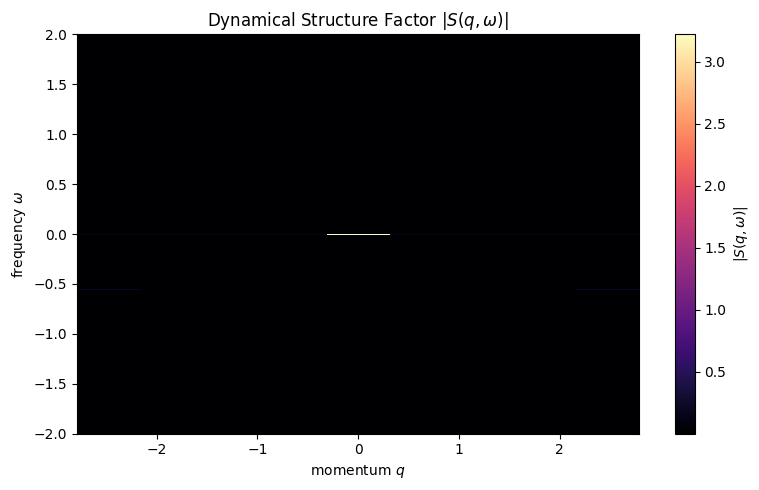

In [ ]:
# --- Fourier transform in time and space ---
C_omega_r = np.fft.fft(C, axis=0)  # Time FT
C_omega_q = np.fft.fftshift(np.fft.fft(C_omega_r, axis=1), axes=1)  # Space FT + shift

# --- Frequency and momentum axes ---
dt = times[1] - times[0]
freqs = np.fft.fftshift(np.fft.fftfreq(T, d=dt))  # ω
q_vals = np.fft.fftshift(2 * np.pi * np.fft.fftfreq(len(r_vals), d=1))  # q

# --- Plot |S(q, ω)| ---
plt.figure(figsize=(8, 5))
plt.imshow(
    np.abs(np.fft.fftshift(C_omega_q, axes=0)),
    extent=[q_vals[0], q_vals[-1], freqs[0], freqs[-1]],
    origin='lower',
    aspect='auto',
    cmap='magma',
    interpolation='none'
)
plt.ylim(-2,2)
plt.xlabel("momentum $q$")
plt.ylabel("frequency $\\omega$")
plt.title("Dynamical Structure Factor $|S(q, \\omega)|$")
plt.colorbar(label="|$S(q, \\omega)$|")
plt.tight_layout()
plt.show()

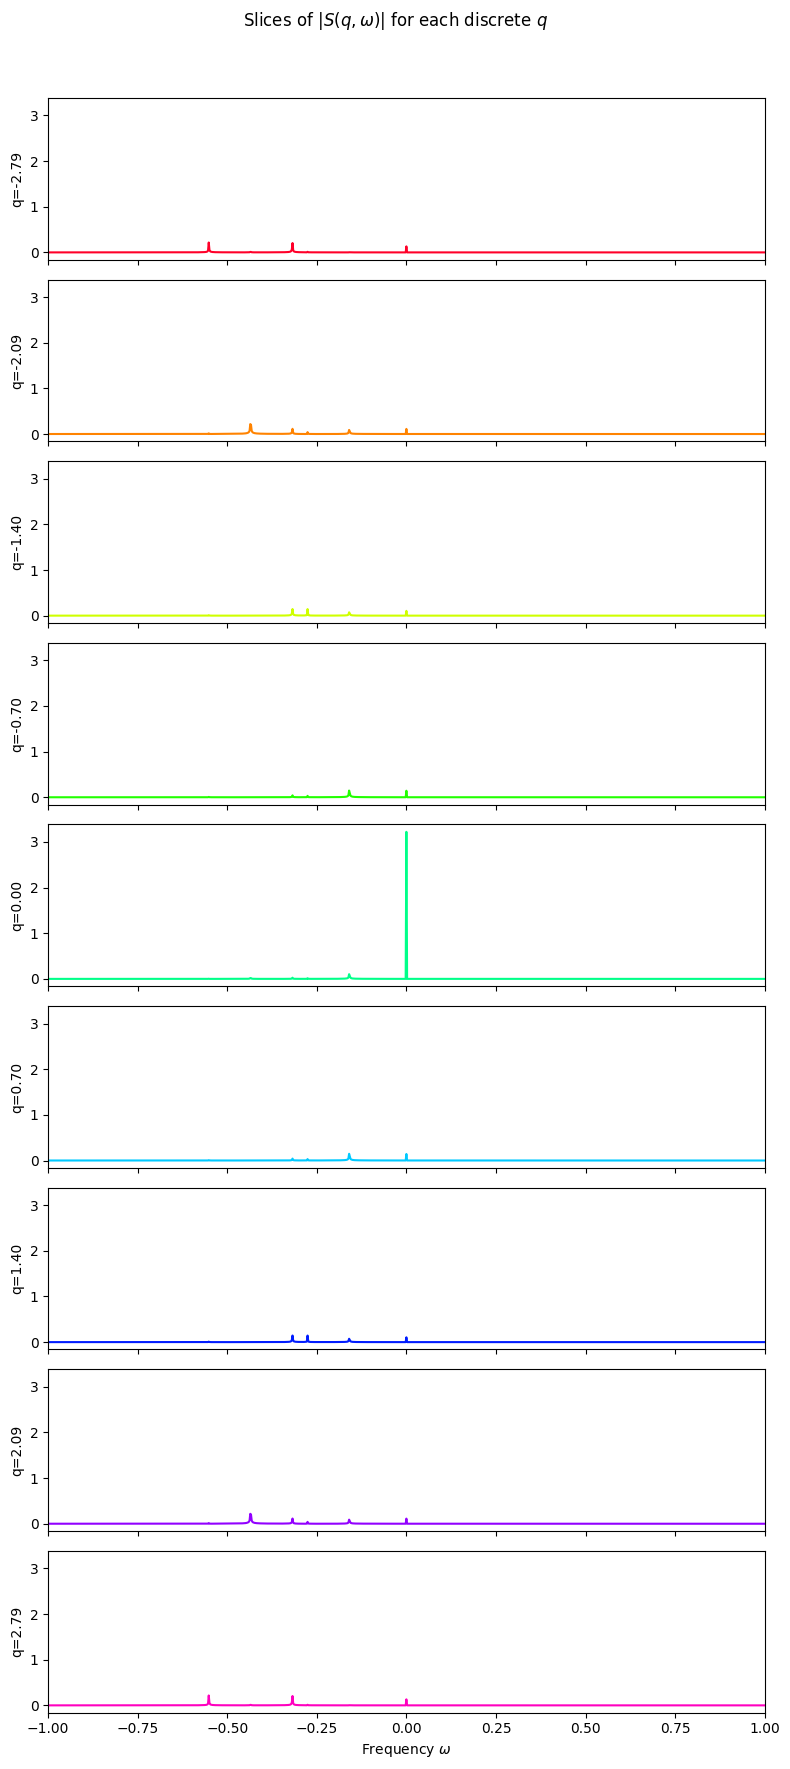

In [ ]:
nrows = len(q_vals)
colors = get_cmap("gist_rainbow", nrows)
fig, axs = plt.subplots(nrows=nrows, figsize=(8, 2*nrows), sharex=True, sharey=True)

for i, q in enumerate(q_vals):
    S_qw = np.abs(np.fft.fftshift(C_omega_q, axes=0)[:, i])
    axs[i].plot(freqs, S_qw, "-", color = colors(i))
    axs[i].set_ylabel(f'q={q:.2f}')
    axs[i].set_xlim(-1, 1)
    if i == nrows - 1:
        axs[i].set_xlabel(r'Frequency $\omega$')

plt.suptitle(r'Slices of $|S(q, \omega)|$ for each discrete $q$')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


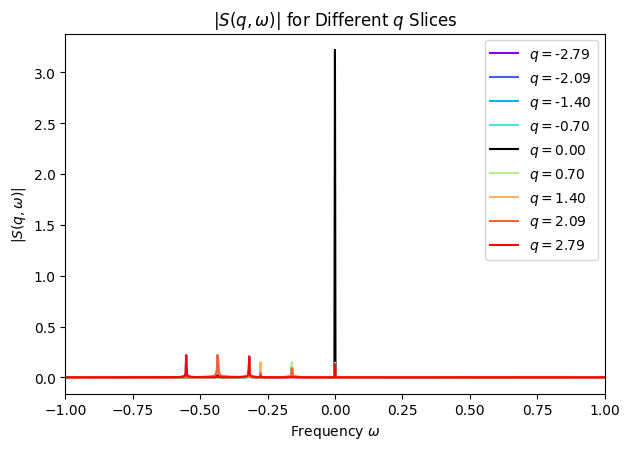

In [ ]:
nrows = len(q_vals)
colors = get_cmap("rainbow", nrows)
fig, ax = plt.subplots()

for i, q in enumerate(q_vals):
    S_qw = np.abs(np.fft.fftshift(C_omega_q, axes=0)[:, i])
    
    if q == 0:
        color = "k"
    else:
        color = colors(i)
        
    ax.plot(freqs, S_qw, "-", color = color, label = f"$q=${q:.2f}")    

ax.set_xlim(-1, 1)
ax.set_xlabel(r'Frequency $\omega$')
ax.set_ylabel("$|S(q,\omega)|$")
ax.legend()
ax.set_title(r'$|S(q, \omega)|$ for Different $q$ Slices')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
